In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

In [3]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


2023-12-08 22:56:45.068849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:56:45.196102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:56:45.196413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:

# Define the function to split the dataset
def split_dataset(base_dir, img_height, img_width, batch_size):
    dataset = image_dataset_from_directory(
        base_dir,
        label_mode='categorical',  # Ensure one-hot encoding
        shuffle=True,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset


In [6]:

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


2023-12-08 22:56:46.523744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:56:46.524234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:56:46.524550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(31, activation='softmax')(x)  # Update to 31 classes
model = Model(inputs=base_model.input, outputs=predictions)


In [8]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:

# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset('dataset-1', 224, 224, 32)


Found 16840 files belonging to 31 classes.


In [10]:
if tf.config.list_physical_devices('GPU'):
    device_name = '/GPU:0'
else:
    device_name = '/CPU:0'
print('Using device:', device_name)

Using device: /GPU:0


In [11]:
with tf.device(device_name):
    history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1 #it will show the progress bar
)

Epoch 1/20


2023-12-08 22:56:57.173782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-08 22:57:00.085206: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2023-12-08 22:57:01.317044: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc425303dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 22:57:01.317096: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-08 22:57:01.328247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702056421.394820  164566 device_compiler.h:186] Compiled cluster using XL

368/368 [==============================] - 147s 376ms/step - loss: 2.2854 - accuracy: 0.3333 - val_loss: 2.0330 - val_accuracy: 0.3884
Epoch 2/20
368/368 [==============================] - 91s 246ms/step - loss: 1.7492 - accuracy: 0.4708 - val_loss: 1.8393 - val_accuracy: 0.4454
Epoch 3/20
368/368 [==============================] - 181s 489ms/step - loss: 1.4383 - accuracy: 0.5611 - val_loss: 1.8173 - val_accuracy: 0.4684
Epoch 4/20
368/368 [==============================] - 118s 320ms/step - loss: 1.1771 - accuracy: 0.6360 - val_loss: 1.9407 - val_accuracy: 0.4537
Epoch 5/20
368/368 [==============================] - 57s 153ms/step - loss: 0.9667 - accuracy: 0.7048 - val_loss: 1.8598 - val_accuracy: 0.4996
Epoch 6/20
368/368 [==============================] - 36s 98ms/step - loss: 0.7844 - accuracy: 0.7642 - val_loss: 1.8496 - val_accuracy: 0.5162
Epoch 7/20
368/368 [==============================] - 112s 299ms/step - loss: 0.6389 - accuracy: 0.8094 - val_loss: 1.9192 - val_accuracy: 

In [12]:

# Optional: Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(test_dataset)
# print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [19]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset-1",
    shuffle=True,
    image_size=(224,224),
    batch_size  = 32
)

Found 16840 files belonging to 31 classes.


In [24]:
classes_names=dataset.class_names

In [26]:
# Assuming classes_names is defined and matches the classes of your dataset
classes_names =   ['Acne and Rosacea Photos',
 'Actinic_keratosis',
 'Atopic Dermatitis Photos',
 'Basal_cell_carcinoma',
 'Bullous Disease Photos',
 'Dermatofibroma',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma',
 'Melanoma Skin Cancer Nevi and Moles',
 'Monkey Pox',
 'Nail Fungus and other Nail Disease',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'bags',
 'benign_keratosis',
 'bopeng',
 'bruntusan',
 'chicken  pox and measles',
 'cystic',
 'melanotic_nevus',
 'papula',
 'pustula']# Replace with your actual class names

First image to predict:


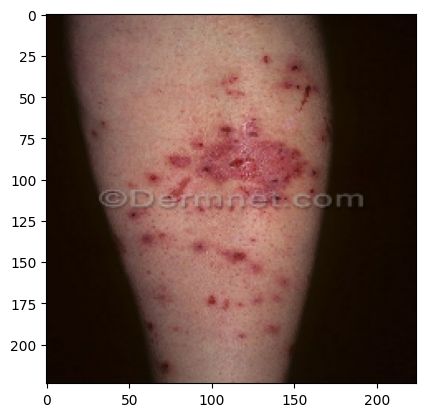

Actual label: Bullous Disease Photos
1/1 [==============================] - 3s 3s/step
Predicted label: Psoriasis pictures Lichen Planus and related diseases


In [27]:
# Predict and visualize the result of a single image from a batch
for image_batch, labels_batch in test_dataset.take(1):
    first_image = image_batch[6].numpy().astype('uint8')
    first_label = np.argmax(labels_batch[6].numpy())  # Use argmax for one-hot encoded labels

    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("Actual label:", classes_names[first_label])
    
    # Batch prediction
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", classes_names[np.argmax(batch_prediction[6])])

In [17]:
#we are not checking with the whole batch we are just checking with 9 images by calling the predicted function and telling how it being predicted

plt.figure(figsize=(15,20))
for images,labels in test_dataset.take():
    for i in range(1):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=classes_names[labels[i]]
        #inorder to print the title we use this
        plt.title(f"Actual:{actual_class},Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis('off')

TypeError: DatasetV2.take() missing 1 required positional argument: 'count'

<Figure size 1500x2000 with 0 Axes>